In [1]:
import trimesh
import potpourri3d as pp3d
import numpy as np
import pyvista as pv
from scipy.spatial import KDTree
import gdist
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict
import random as rd

In [7]:
def unify_vertices(source_file_path, tolerance=1e-5):
    mesh = trimesh.load(source_file_path)
    
    vertices = mesh.vertices
    faces = mesh.faces

    # Step 1: Find unique vertices within the given tolerance
    kdtree = KDTree(vertices)
    unique_indices = {}
    canonical_vertices = []
    
    for i, vertex in enumerate(vertices):
        if i in unique_indices:
            continue  # Skip if already mapped to a canonical vertex
        
        # Find all vertices within the tolerance distance
        duplicate_indices = kdtree.query_ball_point(vertex, tolerance)
        
        # Use the first duplicate as the "canonical" vertex and map all duplicates to it
        canonical_index = len(canonical_vertices)
        canonical_vertices.append(vertex)
        
        for idx in duplicate_indices:
            unique_indices[idx] = canonical_index

    # Step 2: Update faces to use only unique vertices
    new_faces = np.array([[unique_indices[vi] for vi in face] for face in faces])

    # Step 3: Create the new unified mesh
    unified_mesh = trimesh.Trimesh(vertices=np.array(canonical_vertices), faces=new_faces)

    output_path = source_file_path[:-4] + '_fixed.obj'
    unified_mesh.export(output_path)
    print(f'Mesh unified and saved to {output_path}')

In [24]:
def remove_duplicate_edges(source_file_path):
        mesh = trimesh.load(source_file_path)

    edges = mesh.edges
    faces = mesh.faces
    sorted_edges = np.sort(edges, axis=1)

    # Find unique edges
    _, unique_indices = np.unique(sorted_edges, axis=0, return_index=True)
    unique_edges = edges[unique_indices]

    # Find the vertices used by unique edges
    unique_vertices = np.unique(unique_edges)

    # Remap vertices for the unique edges
    vertex_map = {old_index: new_index for new_index, old_index in enumerate(unique_vertices)}
    remapped_vertices = np.array([vertex_map[vertex] for vertex in unique_vertices])

    # Recreate the mesh using the unique edges and remapped vertices
    new_mesh = trimesh.Trimesh(vertices=mesh.vertices[remapped_vertices], faces=faces, process=False)

    output_path = source_file_path[:-4] + '_edges_cleaned.obj'
    new_mesh.export(output_path)
    print(f'Mesh cleaned and saved to {output_path}')


In [8]:
def remove_faces_by_indices(mesh, face_indices):
    # Convert face_indices to a set for fast exclusion
    face_indices_set = set(face_indices)

    # Create a mask that selects all faces except those we want to remove
    mask = [i not in face_indices_set for i in range(len(mesh.faces))]

    # Filter the faces array
    new_faces = mesh.faces[mask]

    # Recreate the mesh with the remaining faces
    new_mesh = trimesh.Trimesh(vertices=mesh.vertices, faces=new_faces, process=False)
    
    return new_mesh

In [12]:
# https://github.com/nmwsharp/robust-laplacians-py/issues/1
def add_random_jitter(mesh, level=1e-5, write_file=False):
    mean_edge_length = mesh.edges_unique_length.mean()
    jittered_vertices = mesh.vertices + np.random.normal(0, mean_edge_length*level, size=mesh.vertices.shape)
    mesh = trimesh.Trimesh(vertices=jittered_vertices, faces= mesh.faces)
    if write_file is not None:
        output_path = f'{write_file[:-4]}_random_faces_{level*100:d}.obj'
        mesh.export(output_path)
        print(f'Mesh jittered and saved to {output_path}')
    return mesh

def preprocess_edges_to_faces(faces):
    edge_to_faces = defaultdict(list)
    for face_idx, face in enumerate(faces):
        # For each face, add its edges to the map
        edges = [(face[i], face[(i + 1) % 3]) for i in range(3)]  # Get edges of the triangle
        for edge in edges:
            sorted_edge = tuple(sorted(edge))  # Sort edge to ensure consistent representation
            edge_to_faces[sorted_edge].append(face_idx)
    return edge_to_faces

def modify_mesh_faces(mesh, level=0.1, write_file=None):
    faces = mesh.faces
    vertices = mesh.vertices
    num_faces_to_modify = int(len(faces) * level)
    modified_faces = faces[:]
    edge_to_faces = preprocess_edges_to_faces(faces)
    modified_indices = set()
    for _ in tqdm(range(num_faces_to_modify)):
        face_idx = np.random.choice([i for i in range(len(modified_faces)) if i not in modified_indices])
        face = modified_faces[face_idx]
        v1, v2 = np.random.choice(face, 2)
        sorted_edge = tuple(sorted((v1, v2)))
        neighbor_face_indices = edge_to_faces[sorted_edge]
        neighbor_face_idx = next((idx for idx in neighbor_face_indices if idx != face_idx and idx not in modified_indices), None)
        
        if neighbor_face_idx is not None:
            neighbor_face = modified_faces[neighbor_face_idx]
            v3 = next(v for v in face if v not in (v1, v2))
            v4 = next(v for v in neighbor_face if v not in (v1, v2))
            modified_faces[face_idx] = [v1, v3, v4]
            modified_faces[neighbor_face_idx] = [v2, v3, v4]
            modified_indices.add(face_idx)
            modified_indices.add(neighbor_face_idx)

    mesh = trimesh.Trimesh(vertices=vertices, faces= modified_faces)
    if write_file is not None:
        output_path = f'{write_file[:-4]}_random_faces_{int(level*100)}.obj'
        mesh.export(output_path)
        print(f'Randomized mesh faces and saved to {output_path}')
    return mesh

def add_holes(mesh, level=0.1, write_file=None):
    faces = mesh.faces
    vertices = mesh.vertices
    remove_indices = np.random.choice(len(faces), int(len(faces) * level), replace=False)
    keep_mask = np.ones(len(faces),dtype=bool)
    keep_mask[remove_indices] = False
    modified_faces = mesh.faces[keep_mask]
    mesh = trimesh.Trimesh(vertices=vertices, faces=modified_faces)
    if write_file is not None:
        output_path = f'{write_file[:-4]}_removed_{int(level*100)}.obj'
        mesh.export(output_path)
        print(f'Randomized mesh faces and saved to {output_path}')
    return mesh

def add_triangle(mesh, new_face, write_file=None):
    vertices = mesh.vertices
    faces = mesh.faces
    print(faces.shape)
    faces = np.append(faces, new_face).reshape(faces.shape[0]+1, 3)
    print(faces.shape)
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    if write_file is not None:
        output_path = f'{write_file[:-4]}_new_face.obj'
        mesh.export(output_path)
        print(f'Extra triangle saved to {output_path}')
    return mesh

In [6]:
'''
for mesh_name in ['stanford-bunny']:
    for noise in [0.03, 0.05]:
        total_mesh_name =f'{mesh_name}_random_faces_{int(noise*100)}.obj'
        mesh = trimesh.load(total_mesh_name)
        add_holes(mesh, noise, total_mesh_name)
'''
hand_mesh_name =f'hand_new_face.obj'
mesh = trimesh.load(hand_mesh_name)
vertices = mesh.vertices
#triangle = np.array([196, 3186, 324])
#196 3186 324
#mesh = add_triangle(mesh, triangle, hand_mesh_name)
#source_vertices = np.concatenate([np.array([196, 3186, 324])])#, np.argsort(mesh.vertices[:,1])[5040:5050]])
#source_vertices = np.concatenate([np.array([8257]), np.argsort(mesh.vertices[:,1])[5000:5010]])#[800,855,860,865,870,875,880])
#5028
#source_vertices = np.argsort(mesh.vertices[:,1])[2500:2502]
source_vertices = np.array([5028, 2223])
#print(source_vertices)
#distances = get_scalar_heat_geodesic(mesh, source_vertices)
show_shm_geodesic(mesh, 5028, 2223)

Widget(value='<iframe src="http://localhost:60755/index.html?ui=P_0x112e483d4b0_0&reconnect=auto" class="pyvis…

In [5]:
def show_mesh(mesh, distances =None, sources= None, intrinsic_vectors=None):
    plotter = pv.Plotter()
    normalized_distances = None
    if distances is not None:
        normalized_distances = (distances - distances.min()) / (distances.max() - distances.min())
        plotter.add_points(mesh.vertices[sources].reshape(sources.shape[0], 3), color="red", render_points_as_spheres=True, point_size=10)
        #plotter.add_point_labels(mesh.vertices[sources].reshape(sources.shape[0], 3), sources.tolist(), point_size=20, font_size=36)
        #for source in sources:
        #    print(source, mesh.vertices[source])
        #    plotter.add_point_labels(mesh.vertices[source],str(source), font_size=20)
    faces_with_sizes = np.hstack([np.full((mesh.faces.shape[0], 1), 3), mesh.faces]).flatten()
    pv_mesh = pv.PolyData(mesh.vertices, faces_with_sizes)
    colors = np.tile(["white", "blue"], 10)
    cmap = ListedColormap(colors)
    plotter.add_mesh(pv_mesh, scalars=normalized_distances, cmap=cmap, show_edges=False)
    
    if intrinsic_vectors is not None:
        vector_solver = pp3d.MeshVectorHeatSolver(mesh.vertices, mesh.faces)
        basisX, basisY, basisN = vector_solver.get_tangent_frames()
        ext3D = intrinsic_vectors[:,0,np.newaxis] * basisX +  intrinsic_vectors[:,1,np.newaxis] * basisY
        mean_edge_length = mesh.edges_unique_length.mean()
        plotter.add_arrows(mesh.vertices, ext3D, mag=mean_edge_length)
    plotter.show(title="Geodesic Distance Visualization")
    plotter.close()

def show_shm_geodesic(mesh, point_a, point_b):
    plotter = pv.Plotter()
    distances = get_scalar_heat_geodesic(mesh, np.array([point_a]))

    track = [point_b]
    edges = mesh.edges
    while track[-1] != point_a:
        current_point = track[-1]
        connected_edges = [edge for edge in edges if current_point in edge]
        vertices = [] 
        for [v1, v2] in connected_edges:
            if v1 == current_point:
                vertices.append(v2)
            else:
                vertices.append(v1)
        next_point = vertices[np.argmin(distances[vertices])]
        track.append(next_point)
    
    plotter.add_lines(mesh.vertices[track], width=3, color='red', connected=True, label=f'Shortest path {distances[point_b]:.2f}')
    faces_with_sizes = np.hstack([np.full((mesh.faces.shape[0], 1), 3), mesh.faces]).flatten()
    pv_mesh = pv.PolyData(mesh.vertices, faces_with_sizes)
    colors = np.tile(["white", "blue"], 10)
    cmap = ListedColormap(colors)
    plotter.add_mesh(pv_mesh, scalars=None, cmap=cmap, show_edges=False)
    plotter.add_legend(bcolor='w', face=None)
    plotter.show(title="Geodesic Distance Visualization")
    plotter.close()

In [4]:
def get_scalar_heat_geodesic(mesh, vertex_indices):
    heat_solver = pp3d.MeshHeatMethodDistanceSolver(mesh.vertices, mesh.faces)
    return heat_solver.compute_distance_multisource(vertex_indices)

In [28]:
def get_exact_geodesic(mesh, vertex_indices):
    vertices = mesh.vertices
    faces = mesh.faces
    geodesic_distances = gdist.compute_gdist(
        vertices.astype(np.float64),
        faces.astype(np.int32),
        vertex_indices
    )
    return geodesic_distances

In [29]:
def get_proximity(distances_exact, distances_approx, epsilon = 0.01):
    distances_exact = (distances_exact - distances_exact.min()) / (distances_exact.max() - distances_exact.min())
    distances_approx = (distances_approx - distances_approx.min()) / (distances_approx.max() - distances_approx.min())
    return np.count_nonzero(np.abs(distances_exact-distances_approx) < epsilon)/distances_exact.shape[0]

In [4]:
source_vertices = np.array([0])
precision_percentage = 2
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
meshes = ['cow.obj']#, 'stanford-bunny.obj', 'horse.obj']

original_vs_noisy_proximities = []
noisy_vs_noisy_proximities = []
for mesh_name in meshes:
    samples = 10
    original_vs_noisy_proximities_current_mesh = np.zeros([samples, len(noise_levels)])
    noisy_vs_noisy_proximities_current_mesh = np.zeros([samples, len(noise_levels)])
    for i, noise in enumerate(noise_levels):
        for j in range(samples):
            mesh = trimesh.load(mesh_name)
            source_vertices = np.random.randint(0, mesh.vertices.shape[0], 1)
            exact_mesh_distances = get_exact_geodesic(mesh, source_vertices)
            jittered_mesh = add_random_jitter(mesh, level=noise)
            exact_jittered_distances = get_exact_geodesic(jittered_mesh, source_vertices)
            shm_jittered_distances = get_scalar_heat_geodesic(jittered_mesh, source_vertices)
            original_vs_noisy_proximities_current_mesh[j, i] = get_proximity(exact_mesh_distances, shm_jittered_distances, precision_percentage/100)
            noisy_vs_noisy_proximities_current_mesh[j, i] = get_proximity(exact_jittered_distances, shm_jittered_distances, precision_percentage/100)
    original_vs_noisy_proximities.append(original_vs_noisy_proximities_current_mesh)
    noisy_vs_noisy_proximities.append(noisy_vs_noisy_proximities_current_mesh)

plt.title('Distance accuracy exact original vs SHM gaussian noise')
plt.xlabel('Noise variance as a % of average edge length')
plt.ylabel(f'% vertex distances off by <{precision_percentage}%')
for i, mesh_name in enumerate(meshes):
    y = original_vs_noisy_proximities[i]
    y_mean = np.percentile(y, 50, axis=0)
    y_lower = np.percentile(y, 25, axis=0)
    y_upper = np.percentile(y, 75, axis=0)
    error_lower = y_mean - y_lower
    error_upper = y_upper - y_mean
    plt.errorbar(noise_levels, y_mean, yerr=[error_lower, error_upper], linewidth=2, label=mesh_name)
plt.legend()
plt.show()

plt.title('Distance accuracy exact vs SHM for gaussian noise')
plt.xlabel('Noise variance as a % of average edge length')
plt.ylabel(f'% vertex <{precision_percentage}% from exact value')
for i, mesh_name in enumerate(meshes):
    y = noisy_vs_noisy_proximities[i]
    y_mean = np.percentile(y, 50, axis=0)
    y_lower = np.percentile(y, 25, axis=0)
    y_upper = np.percentile(y, 75, axis=0)
    error_lower = y_mean - y_lower
    error_upper = y_upper - y_mean
    plt.errorbar(noise_levels, y_mean, yerr=[error_lower, error_upper], linewidth=2, label=mesh_name)
plt.legend()
plt.show()

NameError: name 'get_exact_geodesic' is not defined

Mesh: cow
Noise: 0.01
Noise: 0.02
Noise: 0.03
Noise: 0.04
Noise: 0.05
Mesh: stanford-bunny
Noise: 0.01
Noise: 0.02
Noise: 0.03
Noise: 0.04
Noise: 0.05
Mesh: horse
Noise: 0.01
Noise: 0.02
Noise: 0.03
Noise: 0.04
Noise: 0.05


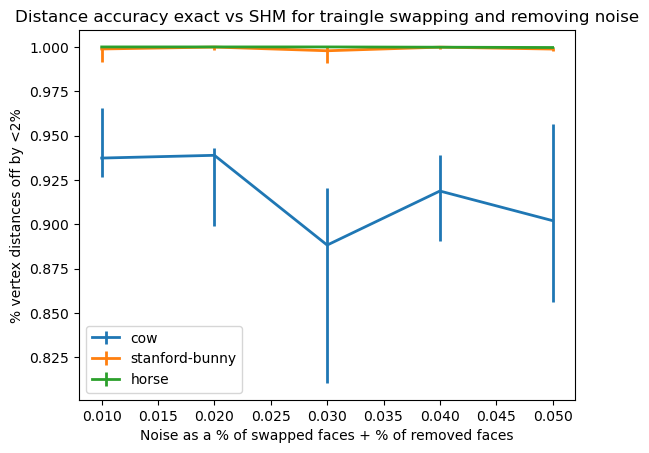

In [34]:
'''
path = f'stanford-bunny_random_faces_2.obj'
swapped_triangles_mesh =  trimesh.load(path)
get_exact_geodesic(swapped_triangles_mesh, np.array([0]))
'''
source_vertices = np.array([0])
precision_percentage = 2
noise_levels = [0.01, 0.02, 0.03, 0.04, 0.05]
meshes = ['cow', 'stanford-bunny', 'horse']

#original_vs_swapped_noisy_proximities = []
noisy_vs_swapped_noisy_proximities = []
for mesh_name in meshes:
    print(f'Mesh: {mesh_name}')
    #path_0 = f'{mesh_name}_random_faces_0.obj'
    #mesh =  trimesh.load(path_0)
    samples = 10
    #original_vs_noisy_proximities_current_mesh = np.zeros([samples, len(noise_levels)])
    noisy_vs_noisy_proximities_current_mesh = np.zeros([samples, len(noise_levels)])
    for i, noise in enumerate(noise_levels):
        print(f'Noise: {noise}')
        path = f'{mesh_name}_random_faces_{int(noise*100)}_removed_{int(noise*100)}.obj'
        swapped_triangles_mesh =  trimesh.load(path)
        for j in range(samples):
            source_vertices = np.random.randint(0, swapped_triangles_mesh.vertices.shape[0], 1)
            #exact_mesh_distances = get_exact_geodesic(mesh, source_vertices)
            exact_swapped_distances = get_exact_geodesic(swapped_triangles_mesh, source_vertices)
            shm_swapped_distances = get_scalar_heat_geodesic(swapped_triangles_mesh, source_vertices)
            #original_vs_noisy_proximities_current_mesh[j, i] = get_proximity(exact_mesh_distances, shm_swapped_distances, precision_percentage/100)
            noisy_vs_noisy_proximities_current_mesh[j, i] = get_proximity(exact_swapped_distances, shm_swapped_distances, precision_percentage/100)
    #original_vs_swapped_noisy_proximities.append(original_vs_noisy_proximities_current_mesh)
    noisy_vs_swapped_noisy_proximities.append(noisy_vs_noisy_proximities_current_mesh)

'''
plt.title('Distance accuracy exact original vs SHM traingle swapping noise')
plt.xlabel('Noise as a % of swapped faces')
plt.ylabel(f'% vertex distances off by <{precision_percentage}%')
for i, mesh_name in enumerate(meshes):
    y = original_vs_swapped_noisy_proximities[i]
    y_mean = np.percentile(y, 50, axis=0)
    y_lower = np.percentile(y, 25, axis=0)
    y_upper = np.percentile(y, 75, axis=0)
    error_lower = y_mean - y_lower
    error_upper = y_upper - y_mean
    plt.errorbar(noise_levels, y_mean, yerr=[error_lower, error_upper], linewidth=2, label=mesh_name)
plt.legend()
plt.show()
'''

plt.title('Distance accuracy exact vs SHM for traingle swapping and removing noise')
plt.xlabel('Noise as a % of swapped faces + % of removed faces')
plt.ylabel(f'% vertex distances off by <{precision_percentage}%')
for i, mesh_name in enumerate(meshes):
    y = noisy_vs_swapped_noisy_proximities[i]
    y_mean = np.percentile(y, 50, axis=0)
    y_lower = np.percentile(y, 25, axis=0)
    y_upper = np.percentile(y, 75, axis=0)
    error_lower = y_mean - y_lower
    error_upper = y_upper - y_mean
    plt.errorbar(noise_levels, y_mean, yerr=[error_lower, error_upper], linewidth=2, label=mesh_name)
plt.legend()
plt.show()
